In [1]:
from fscales import *
from urllib.parse import urljoin

# Download and extract a dataset
DOWNLOAD_ROOT = "https://github.com/AdelEzz5/Scales/raw/refs/heads/main/"      #The base URL where the dataset is hosted
SCALES_PATH = os.path.join("datasets", "scales")                               #The local directory where the dataset will be stored
SCALES_URL = urljoin(DOWNLOAD_ROOT, "datasets/scales.tgz")                     #Full URL to the .tgz dataset file

fetch_scales_data(SCALES_URL, SCALES_PATH)

✅ Dataset already downloaded and extracted.


In [2]:
# load scales.csv file
scales = load_scales_data(SCALES_PATH)
scales.head()

,Furnace Temeprature (c),Time (h),Scale Weight (Kg/m2)
0,559.0,11.9,0.158
1,1186.0,6.0,4.434
2,797.0,9.9,0.809
3,567.0,12.7,0.175
4,939.0,4.8,1.258


In [3]:
scales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Furnace Temeprature (c)  300 non-null    float64
 1   Time (h)                 300 non-null    float64
 2   Scale Weight (Kg/m2)     300 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


In [4]:
# Checking for Missing Values
scales.isnull().sum()

Furnace Temeprature (c)    1
Time (h)                   1
Scale Weight (Kg/m2)       1
dtype: int64

In [5]:
# Clean data
print(f"Before cleaning: {scales.shape[0]} rows")
# Removes rows where at least one column has NaN
scales = scales.dropna() 
print(f"After cleaning: {scales.shape[0]} rows")

Before cleaning: 301 rows
After cleaning: 300 rows


In [6]:
scales.describe()

,Furnace Temeprature (c),Time (h),Scale Weight (Kg/m2)
count,300.000000,300.000000,300.000000
mean,941.816667,13.494000,3.567570
std,257.088489,6.070596,3.673593
min,502.000000,3.000000,0.061000
25%,700.000000,9.200000,0.528000
50%,977.500000,12.800000,2.195000
75%,1172.500000,18.825000,5.421000
max,1345.000000,24.000000,14.146000


Saving figure attribute_pair_plots


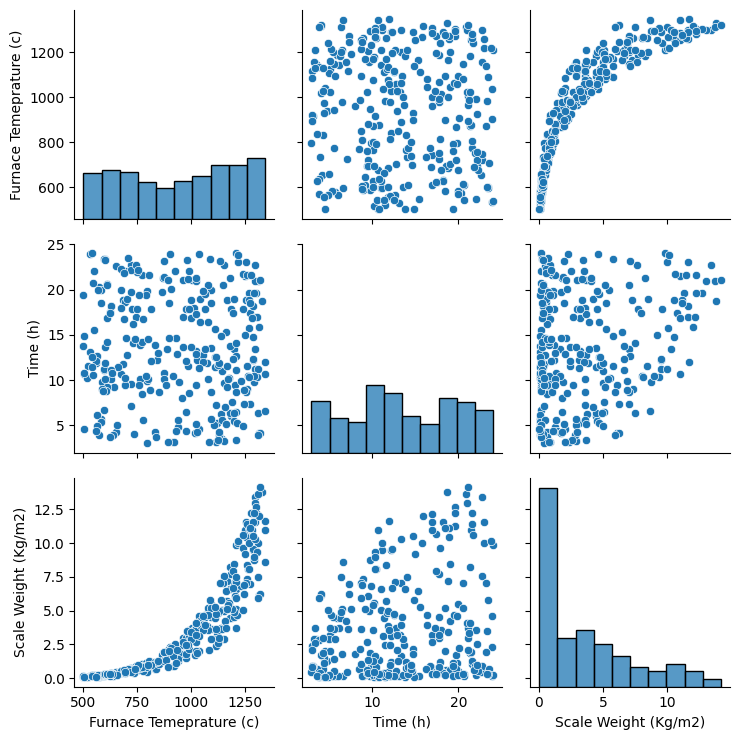

In [7]:
# Data Visualization
sns.pairplot(scales)
save_fig("attribute_pair_plots")
plt.show()

Saving figure boxplots_for_outlier_detection


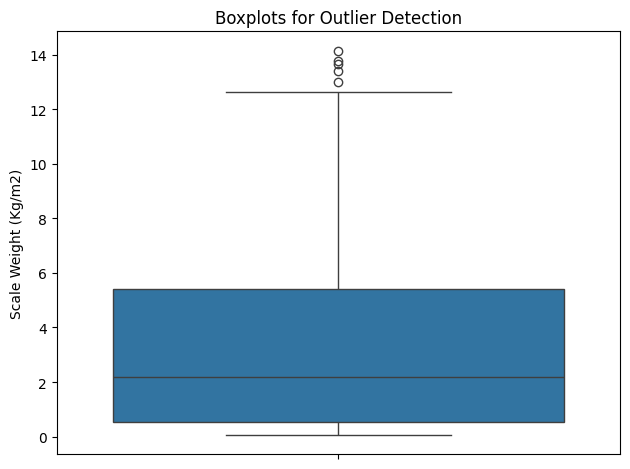

In [8]:
# Visualize Outliers Using Boxplots
plt.figure()
sns.boxplot(data=scales["Scale Weight (Kg/m2)"])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
save_fig("boxplots_for_outlier_detection")
plt.show()

In [9]:
# Using IQR to remove outliers
Q1 = scales.quantile(0.25)
Q3 = scales.quantile(0.75)
IQR = Q3 - Q1

# Keep rows within 1.5 * IQR
scales_clean = scales[~((scales < (Q1 - 1.5 * IQR)) | (scales > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Rows before: {scales.shape[0]}, after removing outliers: {scales_clean.shape[0]}")

Rows before: 300, after removing outliers: 295


In [10]:
#split a dataset into training and testing subsets.
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(scales_clean, test_size=0.2, random_state=42)
print(f"train_size = {len(train_set)}")
print(f"test_size = {len(test_set)}")

train_size = 236
test_size = 59


In [11]:
test_set.head()

,Furnace Temeprature (c),Time (h),Scale Weight (Kg/m2)
278,693.0,9.5,0.400
158,1016.0,18.0,3.587
85,976.0,4.4,1.456
83,597.0,11.1,0.210
266,874.0,10.1,1.283


In [12]:
scales = train_set.copy()

Saving figure scales_scatterplot


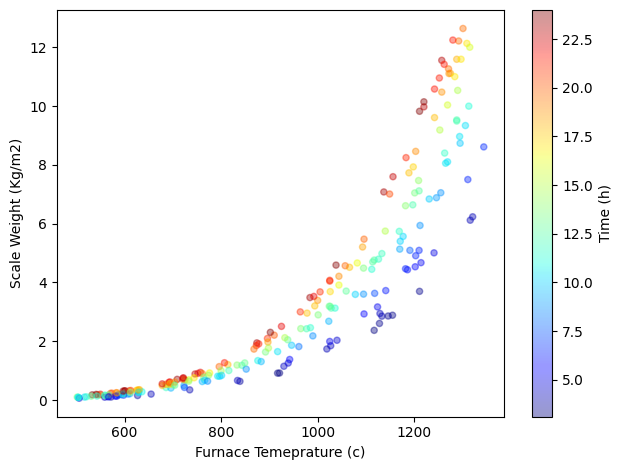

In [13]:
scales.plot(kind="scatter", x="Furnace Temeprature (c)", y="Scale Weight (Kg/m2)", alpha=0.4,
             c="Time (h)", cmap=plt.get_cmap("jet"),colorbar=True)
save_fig("scales_scatterplot")

In [14]:
# standard correlation coefficient
corr_matrix = scales.corr()
corr_matrix["Scale Weight (Kg/m2)"].sort_values(ascending=False)

Scale Weight (Kg/m2)       1.000000
Furnace Temeprature (c)    0.877518
Time (h)                   0.172231
Name: Scale Weight (Kg/m2), dtype: float64

In [15]:
# Prepare the Data for Machine Learning Algorithms
scales = scales.drop("Scale Weight (Kg/m2)", axis=1)           # drop labels for training set
scales_labels = train_set["Scale Weight (Kg/m2)"].copy()

In [16]:
# Train the model using Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Build polynomial regression pipeline
degree = 4
poly_reg_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
    ("lin_reg", LinearRegression())
])
poly_reg_model.fit(scales, scales_labels)

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('lin_reg', LinearRegression())])

In [17]:
# Test the Linear Regression model with Sample Data
some_data = scales.iloc[:5]
some_labels = scales_labels.iloc[:5]
print("Labels:", list(some_labels))
print("Predictions:", poly_reg_model.predict(some_data))

Labels: [1.819, 1.137, 0.183, 4.764, 6.236]
Predictions: [1.84339096 1.13118373 0.17959965 4.77845061 6.31115627]


In [18]:
# Calculating Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error

scales_predictions = poly_reg_model.predict(scales)
lin_mse = mean_squared_error(scales_labels, scales_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE:", "{:.3f}".format(lin_rmse), " Kg/m2")

RMSE: 0.014  Kg/m2


In [19]:
# cross-validation for Linear Regression
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(poly_reg_model, scales, scales_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.02289658 0.01144944 0.01955913 0.01361555 0.02154086 0.01877631
 0.01248898 0.01198872 0.01257952 0.01361932]
Mean: 0.01585144230892089
Standard deviation: 0.004130336541112577


In [20]:
# test set validation
X_test = test_set.drop("Scale Weight (Kg/m2)", axis=1)
y_test = test_set["Scale Weight (Kg/m2)"].copy()

test_predictions = poly_reg_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
print("RMSE:", "{:.3f}".format(test_rmse), " Kg/m2")

RMSE: 0.017  Kg/m2


Saving figure poly_predictions_residuals


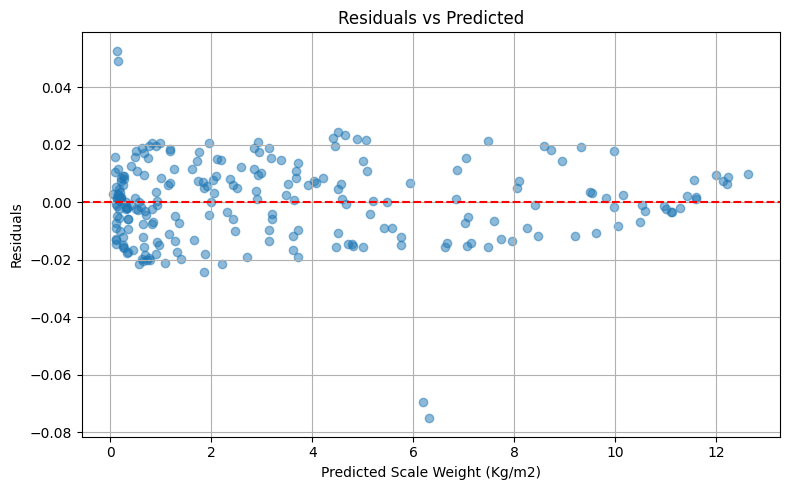

In [21]:
# Predictions and residuals
y_pred = poly_reg_model.predict(scales)
residuals = scales_labels - y_pred

# Plot residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Scale Weight (Kg/m2)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
save_fig("poly_predictions_residuals")
plt.show()

In [22]:
# Save the Linear Regression model to a file
import joblib

joblib.dump(poly_reg_model, "LinearRegression_model.pkl")
print("Model saved as 'LinearRegression_model.pkl'")

Model saved as 'LinearRegression_model.pkl'


In [23]:
# Train the model using Random Forest Regressor model
# find the best combination of hyperparameter values for RandomForestRegressor using GridSearch
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [50, 100, 200], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50, 100], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(scales, scales_labels)

print("Best Params:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
best_model = grid_search.best_estimator_

Best Params: {'max_features': 2, 'n_estimators': 200}
Best Estimator: RandomForestRegressor(max_features=2, n_estimators=200, random_state=42)


In [24]:
# Train the model
forest_reg = grid_search.best_estimator_
forest_reg.fit(scales, scales_labels)

RandomForestRegressor(max_features=2, n_estimators=200, random_state=42)

In [25]:
# Test the Random Forest Regressor model with Sample Data
print("Labels:", list(some_labels))
print("Predictions:", forest_reg.predict(some_data))

Labels: [1.819, 1.137, 0.183, 4.764, 6.236]
Predictions: [1.9637  1.08075 0.18419 4.71212 6.40387]


In [26]:
# Calculating Root Mean Squared Error (RMSE)
scales_predictions = forest_reg.predict(scales)
forest_mse = mean_squared_error(scales_labels, scales_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE:", "{:.3f}".format(forest_rmse), " Kg/m2")

RMSE: 0.127  Kg/m2


In [27]:
# cross-validation for Random Forest Regressor model
forest_scores = cross_val_score(forest_reg, scales, scales_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.17948564 0.2254228  0.22257802 0.55177652 0.26521586 0.17726004
 0.39664701 0.35843863 0.53529452 0.2360801 ]
Mean: 0.31481991331737114
Standard deviation: 0.13257253346952041


In [28]:
# test set validation
final_predictions = forest_reg.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("RMSE:", "{:.3f}".format(final_rmse), " Kg/m2")

RMSE: 0.424  Kg/m2


Saving figure rf_predictions_residuals


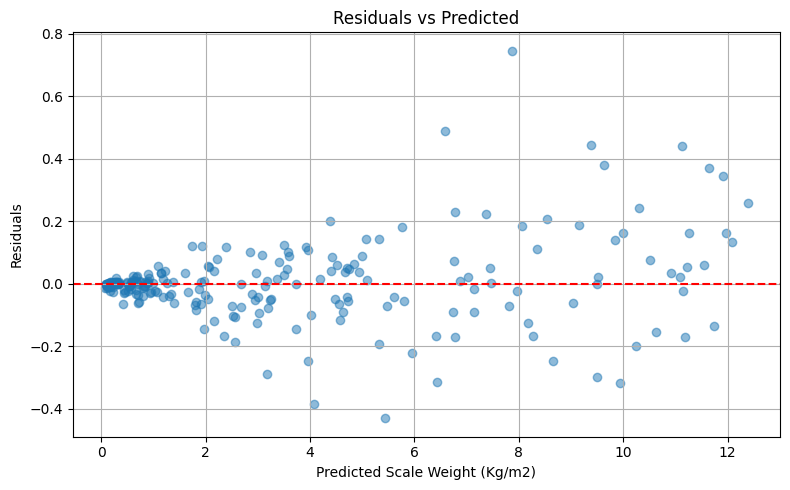

In [29]:
# Predictions and residuals
y_pred = forest_reg.predict(scales)
residuals = scales_labels - y_pred

# Plot residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Scale Weight (Kg/m2)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
save_fig("rf_predictions_residuals")
plt.show()

In [30]:
# Save the Random Forest Regressor model to a file

joblib.dump(forest_reg, "Random_Forest_Regressor_model.pkl")
print("Model saved as 'Random_Forest_Regressor_model.pkl'")

Model saved as 'Random_Forest_Regressor_model.pkl'


In [31]:
# Scale Weight Prediction GUI
# Select a machine learning model and input Furnace Temperature and Time to predict the Scale Weight (Kg/m²)
%run GUI.py